# Load and Preview Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("../data/fraud_mock.csv")
df.head()

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
2,1,TRANSFER,181.00,acc1796908,181.0,0.00,acc4938640,0.0,0.0,1,0
3,1,CASH_OUT,181.00,acc4182296,181.0,0.00,acc1221153,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0


# 1. Data Quality Checks

In [5]:
# Display basic shape and data types
print("Shape of dataset:", df.shape)
print("\nColumn data types:")
print(df.dtypes)

Shape of dataset: (6362620, 11)

Column data types:
time_ind              int64
transac_type         object
amount              float64
src_acc              object
src_bal             float64
src_new_bal         float64
dst_acc              object
dst_bal             float64
dst_new_bal         float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object


In [6]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64


In [7]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_count)


Number of duplicate rows: 0


The data looks good — there are no missing values, and no duplicate records are present.

In [8]:
# Summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
           time_ind        amount       src_bal   src_new_bal       dst_bal  \
count  6.362620e+06  6.362620e+06  6.362620e+06  6.362620e+06  6.362620e+06   
mean   2.433972e+02  1.798619e+05  8.338831e+05  8.551137e+05  1.100702e+06   
std    1.423320e+02  6.038582e+05  2.888243e+06  2.924049e+06  3.399180e+06   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.560000e+02  1.338957e+04  0.000000e+00  0.000000e+00  0.000000e+00   
50%    2.390000e+02  7.487194e+04  1.420800e+04  0.000000e+00  1.327057e+05   
75%    3.350000e+02  2.087215e+05  1.073152e+05  1.442584e+05  9.430367e+05   
max    7.430000e+02  9.244552e+07  5.958504e+07  4.958504e+07  3.560159e+08   

        dst_new_bal      is_fraud  is_flagged_fraud  
count  6.362620e+06  6.362620e+06      6.362620e+06  
mean   1.224996e+06  1.290820e-03      2.514687e-06  
std    3.674129e+06  3.590480e-02      1.585775e-03  
min    0.000000e+00  0.000000e+00      0.000000e+00

In [9]:
# Total number of rows
total_rows = len(df)

# Count and percentage of unique values per column
unique_counts = df.nunique()
unique_percentages = (unique_counts / total_rows * 100).round(2)

# Combine into a DataFrame for clearer output
unique_summary = pd.DataFrame({
    "unique_count": unique_counts,
    "unique_percent": unique_percentages
})

print("\nUnique values per column (count and percentage):")
print(unique_summary)



Unique values per column (count and percentage):
                  unique_count  unique_percent
time_ind                   743            0.01
transac_type                 5            0.00
amount                 5316900           83.56
src_acc                6353307           99.85
src_bal                1845844           29.01
src_new_bal            2682586           42.16
dst_acc                2722362           42.79
dst_bal                3614697           56.81
dst_new_bal            3555499           55.88
is_fraud                     2            0.00
is_flagged_fraud             2            0.00


This show there is almost 100 percent that source account not the same person and the traget is more like 50 persent

In [10]:
# Fraud class distribution
print("\nFraud vs Non-Fraud distribution:")
print(df['is_fraud'].value_counts(normalize=True).rename("ratio").to_frame().assign(count=df['is_fraud'].value_counts()))


Fraud vs Non-Fraud distribution:
             ratio    count
is_fraud                   
0         0.998709  6354407
1         0.001291     8213


This is undesirable but expected — fraudulent transactions are a minority class, which results in an imbalanced classification problem.

# 2. Pre-Insight : bussiness logic Checklist

Before proceeding with exploratory analysis, we first verify the dataset’s integrity by checking for logical consistency and conformance with known business rules.

---

### 2.1. Validation of Transaction Logic by Type

Each transaction type dictates how the sender’s balance (`src_new_bal`) should change in relation to the original balance (`src_bal`) and the transaction `amount`. The expected logic per type is as follows:

| `transac_type` | Expected Balance Logic            |
|----------------|-----------------------------------|
| `CASH-IN`      | `src_new_bal = src_bal + amount`  |
| `CASH-OUT`     | `src_new_bal = src_bal - amount`  |
| `PAYMENT`      | `src_new_bal = src_bal - amount`  |
| `TRANSFER`     | `src_new_bal = src_bal - amount`  |
| `DEBIT`        | `src_new_bal = src_bal - amount`  |

We implement programmatic checks across all records to identify inconsistencies or data integrity violations.

In [11]:
def check_balance_logic(df):
    """
    Check if src_new_bal is consistent with src_bal and amount for each transac_type.
    Returns a DataFrame with violations.
    """
    df = df.copy()  # Avoid modifying original

    # Expected new balance based on transaction type
    conditions = {
        "CASH-IN": df["src_bal"] + df["amount"],
        "CASH-OUT": df["src_bal"] - df["amount"],
        "PAYMENT": df["src_bal"] - df["amount"],
        "TRANSFER": df["src_bal"] - df["amount"],
        "DEBIT": df["src_bal"] - df["amount"],
    }

    # Container for invalid entries
    all_violations = []

    for tx_type, expected_balance in conditions.items():
        mask = df["transac_type"] == tx_type

        # Select only matching rows for both Series
        expected = expected_balance[mask]
        actual = df.loc[mask, "src_new_bal"]

        mismatches = df.loc[mask].loc[~np.isclose(actual, expected)]

        if not mismatches.empty:
            mismatches = mismatches.assign(expected_src_new_bal=expected)
            all_violations.append(mismatches)
            print(f"{len(mismatches):,} invalid '{tx_type}' transactions (source balance logic mismatch).")

    if all_violations:
        violations_df = pd.concat(all_violations)
        return violations_df

    print("All transactions follow source balance logic.")
    return pd.DataFrame()

In [12]:
violations = check_balance_logic(df)

1,102,074 invalid 'PAYMENT' transactions (source balance logic mismatch).
507,545 invalid 'TRANSFER' transactions (source balance logic mismatch).
11,795 invalid 'DEBIT' transactions (source balance logic mismatch).


In [13]:
violations.head()

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud,expected_src_new_bal
8,1,PAYMENT,4024.36,acc5428218,2671.00,0.0,acc291243,0.0,0.0,0,0,-1353.36
13,1,PAYMENT,11633.76,acc3180839,10127.00,0.0,acc805084,0.0,0.0,0,0,-1506.76
16,1,PAYMENT,1563.82,acc4301678,450.00,0.0,acc667586,0.0,0.0,0,0,-1113.82
25,1,PAYMENT,6061.13,acc5288285,443.00,0.0,acc6255982,0.0,0.0,0,0,-5618.13
28,1,PAYMENT,8901.99,acc8799771,2958.91,0.0,acc1815446,0.0,0.0,0,0,-5943.08


In [14]:
violations['is_fraud'].value_counts()

is_fraud
0    1621393
1         21
Name: count, dtype: int64

Fraud rate in violating transactions: 0.0013%
Overall fraud rate: 0.1291%


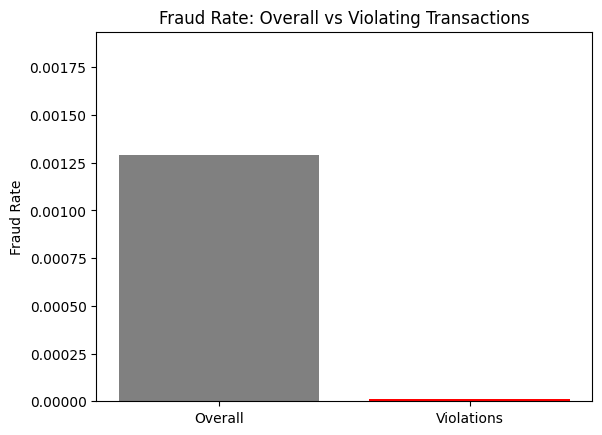

In [15]:
# Step 1: Compute fraud rate in violation set
violation_fraud_rate = violations['is_fraud'].mean()

# Step 2: Compute fraud rate in the entire dataset
overall_fraud_rate = df['is_fraud'].mean()

# Step 3: Print results
print(f"Fraud rate in violating transactions: {violation_fraud_rate:.4%}")
print(f"Overall fraud rate: {overall_fraud_rate:.4%}")

plt.bar(["Overall", "Violations"], [overall_fraud_rate, violation_fraud_rate], color=["gray", "red"])
plt.title("Fraud Rate: Overall vs Violating Transactions")
plt.ylabel("Fraud Rate")
plt.ylim(0, max(overall_fraud_rate, violation_fraud_rate) * 1.5)
plt.show()


In [16]:
# Balance mismatch
df['src_bal_diff'] = df['src_bal'] - df['amount']
df['src_mismatch'] = ~np.isclose(df['src_new_bal'], df['src_bal_diff'])
print(f"Sender balance mismatch: {df['src_mismatch'].mean():.2%}")

# Create mask for non-merchant transactions
non_merchant_mask = ~df['transac_type'].isin(['PAYMENT', 'DEBIT'])

# Compute destination balance difference only for non-merchant rows
df.loc[non_merchant_mask, 'dst_bal_diff'] = df.loc[non_merchant_mask, 'dst_bal'] + df.loc[non_merchant_mask, 'amount']

# Compare with dst_new_bal to detect mismatch
df.loc[non_merchant_mask, 'dst_mismatch'] = ~np.isclose(
    df.loc[non_merchant_mask, 'dst_new_bal'],
    df.loc[non_merchant_mask, 'dst_bal_diff']
)

# Report mismatch rate
mismatch_rate = df.loc[non_merchant_mask, 'dst_mismatch'].mean()
print(f"Recipient balance mismatch (non-merchant): {mismatch_rate:.2%}")


Sender balance mismatch: 78.61%
Recipient balance mismatch (non-merchant): 40.03%


### 2.2. Verification of Rule-Based Fraud Flags

The `is_flagged_fraud` column serves as a **rule-based indicator**, likely derived from a heuristic such as:

- All transactions flagged (`is_flagged_fraud == 1`) have `amount > 200,000`
- All flagged transactions are also confirmed frauds (`is_fraud == 1`)
- However, **not all** true frauds (`is_fraud == 1`) are flagged — implying:
  - Some fraudulent cases are missed by the rule
  - The flag is selective and does not comprehensively detect fraud

This validation step helps clarify the role of `is_flagged_fraud` in modeling, emphasizing the need for machine learning to detect the unflagged fraudulent behavior.

In [17]:
# Transactions where is_flagged_fraud is True
flagged = df[df['is_flagged_fraud'] == 1]
flagged_types = flagged['transac_type'].value_counts().to_dict()

# Check if any flagged transactions have amount <= 200,000
violations = flagged[flagged['amount'] <= 200_000]
violation_types = violations['transac_type'].value_counts().to_dict()

# Summary output
print(f"There are total {len(flagged):,} transactions flagged as fraud attempts.")
print("Their transaction types are:")
for tx_type, count in flagged_types.items():
    print(f"  - {tx_type}: {count}")

print(f"Out of these, {len(violations):,} transactions have amount ≤ 200,000, which violates the rule logic.")


There are total 16 transactions flagged as fraud attempts.
Their transaction types are:
  - TRANSFER: 16
Out of these, 0 transactions have amount ≤ 200,000, which violates the rule logic.


Proof that All flagged transactions are also labeled as fraud. But all frauds are not also labeled as flagged transactions

In [18]:
flagged = df[df['is_flagged_fraud'] == 1]
violations_flagged = flagged[flagged['is_fraud'] != 1]

print(f"Total is_flagged_fraud == 1: {len(flagged):,}")
print(f"Violations where is_flagged_fraud == 1 but is_fraud != 1: {len(violations_flagged):,}")

if len(violations_flagged) == 0:
    print("All flagged transactions are also labeled as fraud (is_fraud == 1).")
else:
    print("Some flagged transactions are not marked as fraud!")


Total is_flagged_fraud == 1: 16
Violations where is_flagged_fraud == 1 but is_fraud != 1: 0
All flagged transactions are also labeled as fraud (is_fraud == 1).


In [19]:
frauds = df[df['is_fraud'] == 1]
unflagged_frauds = frauds[frauds['is_flagged_fraud'] == 0]

print(f"Total is_fraud == 1: {len(frauds):,}")
print(f"Fraudulent but not flagged: {len(unflagged_frauds):,}")

if len(unflagged_frauds) > 0:
    print("As expected, many fraudulent transactions are not flagged (rule doesn't catch all).")
else:
    print("All fraudulent transactions are also flagged — unexpected if rule isn't comprehensive.")


Total is_fraud == 1: 8,213
Fraudulent but not flagged: 8,197
As expected, many fraudulent transactions are not flagged (rule doesn't catch all).


# 3. Correlation and Fraudulent Transaction Pattern

In [20]:
fraud_df = df[df['is_fraud'] == 1]

In [21]:
# Most frequent fraudulent src_acc
top_fraud_sources = fraud_df['src_acc'].value_counts().head(5)
print("Top fraudulent sources:\n", top_fraud_sources)

# Most frequent fraudulent dst_acc
top_fraud_sources = fraud_df['dst_acc'].value_counts().head(5)
print("Top fraudulent destination:\n", top_fraud_sources)


Top fraudulent sources:
 src_acc
acc1796908    1
acc8843145    1
acc3097499    1
acc4279917    1
acc2699164    1
Name: count, dtype: int64
Top fraudulent destination:
 dst_acc
acc1531907    2
acc4778201    2
acc5597152    2
acc4852313    2
acc7548199    2
Name: count, dtype: int64


In [22]:
# How many unique src/dst accounts?
print(f"Unique src_acc: {df['src_acc'].nunique():,}")
print(f"Unique dst_acc: {df['dst_acc'].nunique():,}")

Unique src_acc: 6,353,307
Unique dst_acc: 2,722,362


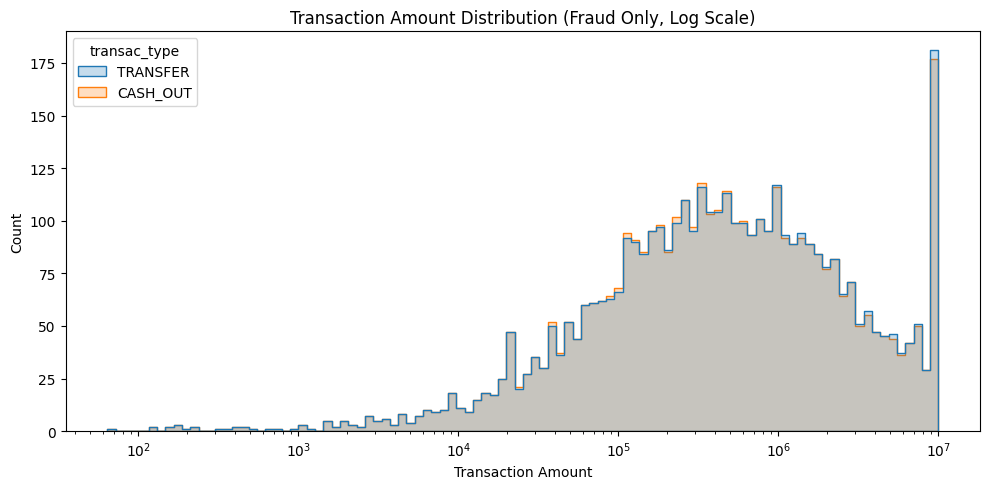

In [23]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=fraud_df, x="amount", bins=100, hue="transac_type", log_scale=(True, False), element="step", color="red")
plt.title("Transaction Amount Distribution (Fraud Only, Log Scale)")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

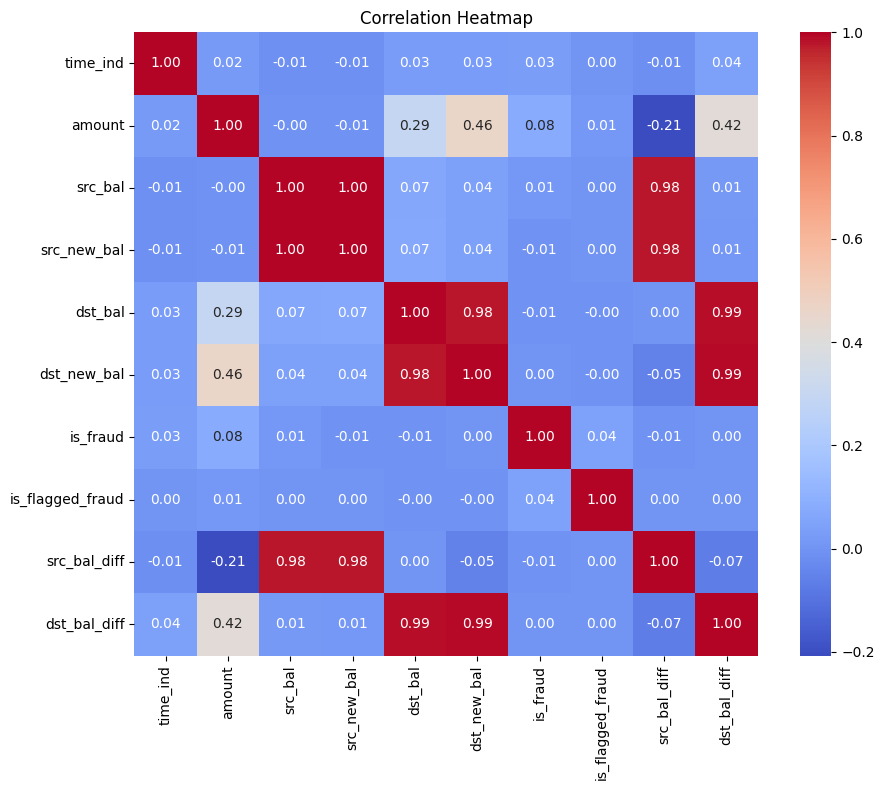

In [24]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


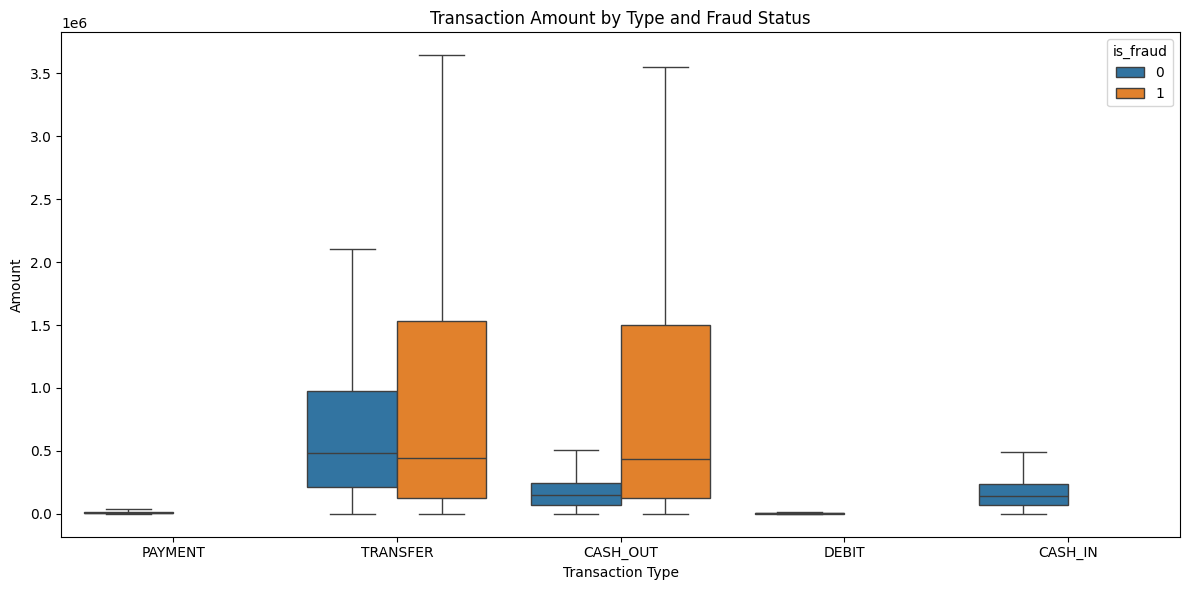

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="transac_type", y="amount", hue="is_fraud", showfliers=False)
plt.title("Transaction Amount by Type and Fraud Status")
plt.xlabel("Transaction Type")
plt.ylabel("Amount")
plt.tight_layout()
plt.show()
